In [18]:
import tarfile
import os
import pandas as pd
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from io import TextIOWrapper
import seaborn as sns
import matplotlib.pyplot as plt

### Loading Data

In [2]:
os.makedirs("../data/train", exist_ok=True)
os.makedirs("../data/test", exist_ok=True)

In [3]:
train_tar = "SMNI_CMI_TRAIN.tar.gz"
test_tar = "SMNI_CMI_TEST.tar.gz"

In [4]:
def extract_tar_gz(file_path, extract_to):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=extract_to)
    print(f"Extracted {file_path} to {extract_to}")

In [5]:
extract_tar_gz("data/SMNI_CMI_TRAIN.tar.gz", "data/train")
extract_tar_gz("data/SMNI_CMI_TEST.tar.gz", "data/test")

Extracted data/SMNI_CMI_TRAIN.tar.gz to data/train
Extracted data/SMNI_CMI_TEST.tar.gz to data/test


In [6]:
def import_eeg_file(file_obj, df_type='wide', optimize=True):
    # Internal parsing functions
    def parse_subject(line):
        return line[2:-4]

    def parse_alcoholic(line):
        char = line.strip('# ')[3]
        return True if char == 'a' else False

    def parse_obj(line):
        char = line.strip('# ')[1]
        return True if char == '1' else False

    def parse_match(line):
        string = line.strip('# ').split(',')[0].split(' ')[1]
        if string == 'nomatch':
            return 'nomatch'
        elif string == 'obj':
            return 'obj'
        elif string == 'match':
            return 'match'

    def parse_err(line):
        strings = line.strip('# ').split(',')[0].split(' ')
        if len(strings) == 3 and strings[2] == 'err':
            return True
        else:
            return False
    
    # Ensure file_obj is a TextIOWrapper
    if isinstance(file_obj, TextIOWrapper):
        text_obj = file_obj
    else:
        text_obj = TextIOWrapper(file_obj)

    # Read the header information
    header = []
    loc = None
    while True:
        loc = text_obj.tell()
        newline = text_obj.readline()
        if newline[0] == "#":
            header.append(newline)
        else:
            text_obj.seek(loc)
            break

    # Parse the header fields
    subject = parse_subject(header[0])
    alcoholic = parse_alcoholic(header[0])
    obj = parse_obj(header[3])
    match = parse_match(header[3])
    err = parse_err(header[3])

    # Read the EEG data into a DataFrame
    df = pd.read_csv(text_obj, sep=' ', header=None, names=['trial', 'sensor', 'sample', 'value'], comment='#')

    # Add parsed header info as columns
    df['alcoholic'] = alcoholic
    df['object'] = obj
    df['match'] = match
    df['err'] = err
    df['subject'] = subject

    # Reorder columns to make them more intuitive
    df = df[['subject', 'trial', 'alcoholic', 'match', 'err', 'sensor', 'sample', 'value']]

    # Optimize data types
    if optimize:
        df[['trial', 'sample']] = df[['trial', 'sample']].apply(pd.to_numeric, downcast='unsigned')
        df['value'] = df['value'].astype(np.float32)
        df['sensor'] = pd.Categorical(df['sensor'])
        df['match'] = pd.Categorical(df['match'])
        df['subject'] = pd.Categorical(df['subject'])

    # Pivot or reshape the dataframe based on the specified `df_type`
    if df_type == 'wide':
        # Pivot the data to a wide format where each sensor's value is a separate column
        df_wide = df.pivot_table(values='value', index=['sample'], columns=['sensor'], aggfunc='mean')
        df_wide.columns = [f'{col}' for col in df_wide.columns]
        df_wide.reset_index(inplace=True)
        df_wide['subject'] = subject
        df_wide['alcoholic'] = alcoholic
        df_wide['match'] = match
        df_wide['err'] = err
        df_wide['object'] = obj

        return df_wide

    if df_type == 'long':
        # For the long format, we use multi-level indexing
        df_long = df.set_index(['subject', 'trial', 'alcoholic', 'match', 'err', 'sample'])
        return df_long

    return df  

In [7]:
def load_eeg_data(directory, df_type='wide'):
    all_data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".gz"):  # EEG files are compressed
                file_path = os.path.join(root, file)
                with gzip.open(file_path, 'rt') as f:
                    df = import_eeg_file(f, df_type=df_type)  # Use the provided function

                    # Append the dataframe to the list without concatenation yet
                    all_data.append(df)
    
    # Now concatenate all data in one go, which should be more efficient
    combined_df = pd.concat(all_data, axis=0, ignore_index=True)

    # Free memory from the all_data list once we have concatenated
    del all_data

    # Make sure the DataFrame columns are not duplicated by renaming if necessary
    return combined_df

In [10]:
train_df = load_eeg_data("data/train/SMNI_CMI_TRAIN")
test_df = load_eeg_data("data/test/SMNI_CMI_TEST")

/tmp/ipykernel_2730/2018980919.py:79: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_wide = df.pivot_table(values='value', index=['sample'], columns=['sensor'], aggfunc='mean')
/tmp/ipykernel_2730/2018980919.py:79: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_wide = df.pivot_table(values='value', index=['sample'], columns=['sensor'], aggfunc='mean')
/tmp/ipykernel_2730/2018980919.py:79: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_wide = df.pivot_table(values='value', index=['sample'], columns

In [5]:
train_df = pd.read_csv("data/train/train_df.csv")

In [6]:
test_df = pd.read_csv("data/test/test_df.csv")

In [7]:
print("✅ Train Data Shape:", train_df.shape)
print("✅ Test Data Shape:", test_df.shape)

✅ Train Data Shape: (153600, 70)
✅ Test Data Shape: (153600, 70)


In [10]:
train_df.head()

,sample,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,C4,...,TP7,TP8,X,Y,nd,subject,alcoholic,match,err,object
0,0,6.114,6.083,-4.771,4.496,6.673,3.387,2.777,2.045,-2.625,...,3.662,0.763,10.579,9.308,7.080,co2c0000342,False,obj,False,True
1,1,5.137,5.107,1.088,4.008,5.697,-0.031,-0.153,1.556,-4.089,...,3.662,1.251,9.115,8.331,7.080,co2c0000342,False,obj,False,True
2,2,6.114,5.107,10.854,5.473,5.697,-2.960,-2.106,1.068,-2.625,...,3.174,0.763,6.673,6.866,7.568,co2c0000342,False,obj,False,True
3,3,7.090,5.595,17.690,7.426,6.673,-1.007,1.801,0.580,-0.671,...,2.686,-0.702,3.743,6.378,8.545,co2c0000342,False,obj,False,True
4,4,7.579,5.595,17.690,7.426,6.673,1.923,6.195,-0.397,0.305,...,2.197,-1.678,2.767,5.890,8.057,co2c0000342,False,obj,False,True


In [13]:
test_df.head()

,sample,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,C4,...,TP7,TP8,X,Y,nd,subject,alcoholic,match,err,object
0,0,-2.797,-3.448,-0.305,-4.089,-2.797,0.315,1.088,0.651,2.370,...,-8.860,-0.071,-5.544,-4.873,-4.089,co2a0000377,True,nomatch,False,False
1,1,-2.309,-3.937,1.160,-5.066,-3.286,0.804,1.088,1.628,1.882,...,-8.372,0.417,-6.032,-1.943,-0.183,co2a0000377,True,nomatch,False,False
2,2,-1.333,-3.448,2.625,-5.554,-2.797,1.292,0.600,3.092,1.882,...,-3.977,0.905,-4.079,1.475,3.723,co2a0000377,True,nomatch,False,False
3,3,-0.356,-2.472,2.136,-5.066,-1.821,0.804,0.600,3.092,1.394,...,3.347,0.905,-1.149,3.428,5.188,co2a0000377,True,nomatch,False,False
4,4,0.621,-1.495,1.160,-4.578,-0.844,0.315,0.112,2.604,0.417,...,10.183,-0.071,2.268,3.916,2.747,co2a0000377,True,nomatch,False,False


In [14]:
train_df.columns

Index(['sample', 'AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ', 'F1',
       'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4',
       'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ', 'O1',
       'O2', 'OZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1',
       'PO2', 'PO7', 'PO8', 'POZ', 'PZ', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y',
       'nd', 'subject', 'alcoholic', 'match', 'err', 'object'],
      dtype='object')

In [15]:
train_df.to_csv('data/train/train_df.csv', index=False)
test_df.to_csv('data/test/test_df.csv', index=False)

In [16]:
train_df = pd.read_csv('data/train/train_df.csv')
test_df = pd.read_csv('data/test/test_df.csv')

In [17]:
print("Dataset Info:")
print(train_df.info())

print("\nSummary Statistics:")
print(train_df.describe())

print("\nMissing Values:")
print(train_df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153600 entries, 0 to 153599
Data columns (total 70 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sample     153600 non-null  int64  
 1   AF1        153600 non-null  float64
 2   AF2        153600 non-null  float64
 3   AF7        153600 non-null  float64
 4   AF8        153600 non-null  float64
 5   AFZ        153600 non-null  float64
 6   C1         153600 non-null  float64
 7   C2         153600 non-null  float64
 8   C3         153600 non-null  float64
 9   C4         153600 non-null  float64
 10  C5         153600 non-null  float64
 11  C6         153600 non-null  float64
 12  CP1        153600 non-null  float64
 13  CP2        153600 non-null  float64
 14  CP3        153600 non-null  float64
 15  CP4        153600 non-null  float64
 16  CP5        153600 non-null  float64
 17  CP6        153600 non-null  float64
 18  CPZ        153600 non-null  float64
 19  CZ       

### EDA

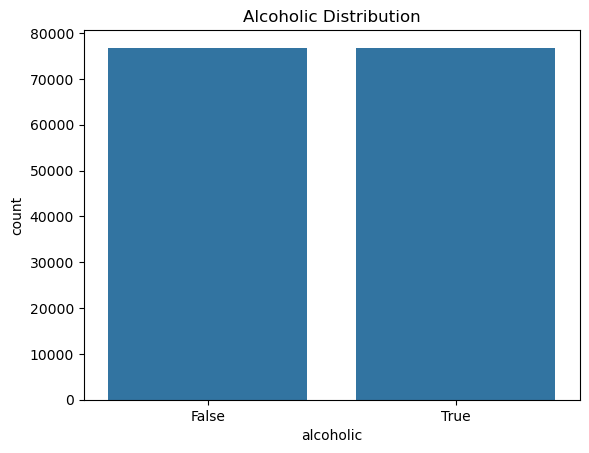

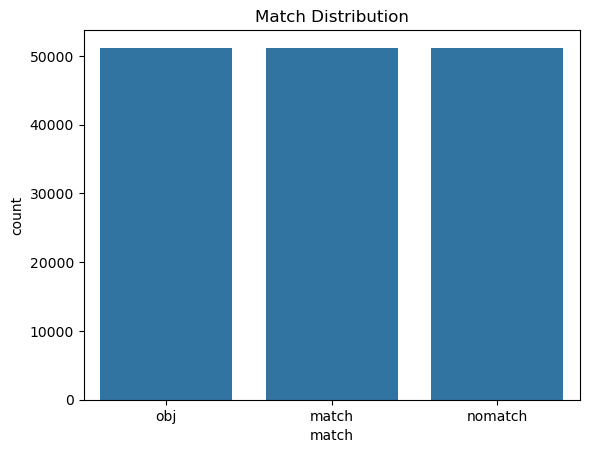

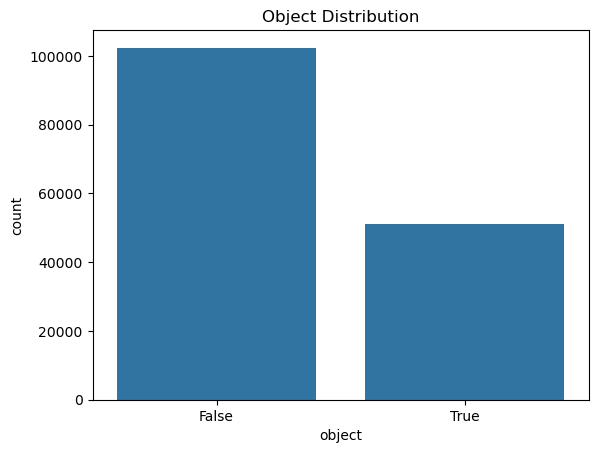

20


In [25]:
# Plot for 'alcoholic'
sns.countplot(data=train_df, x='alcoholic')
plt.title('Alcoholic Distribution')
plt.show()

# Plot for 'match'
sns.countplot(data=train_df, x='match')
plt.title('Match Distribution')
plt.show()

# Plot for 'object'
sns.countplot(data=train_df, x='object')
plt.title('Object Distribution')
plt.show()

# Check unique subjects
print(train_df['subject'].nunique())

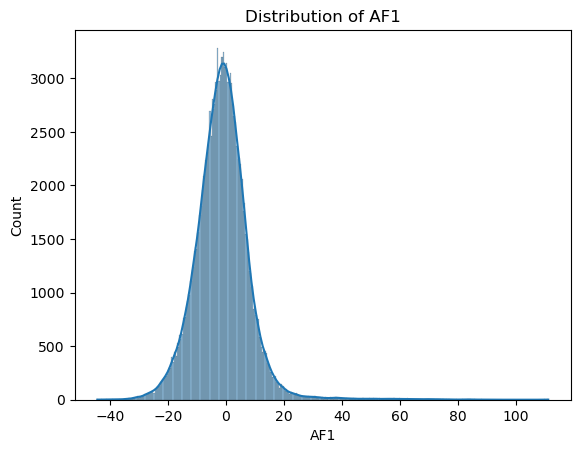

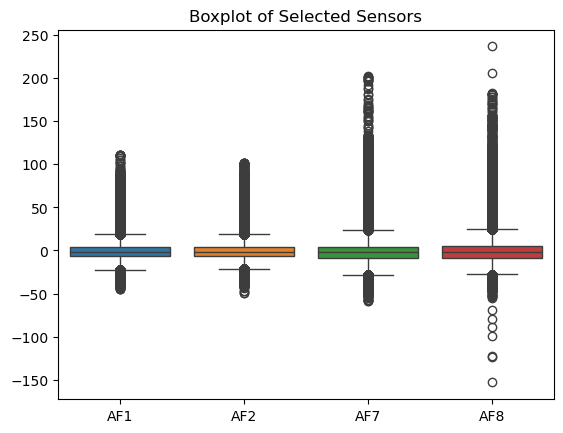

In [26]:
sns.histplot(train_df['AF1'], kde=True)
plt.title('Distribution of AF1')
plt.show()

sns.boxplot(data=train_df[['AF1', 'AF2', 'AF7', 'AF8']])
plt.title('Boxplot of Selected Sensors')
plt.show()


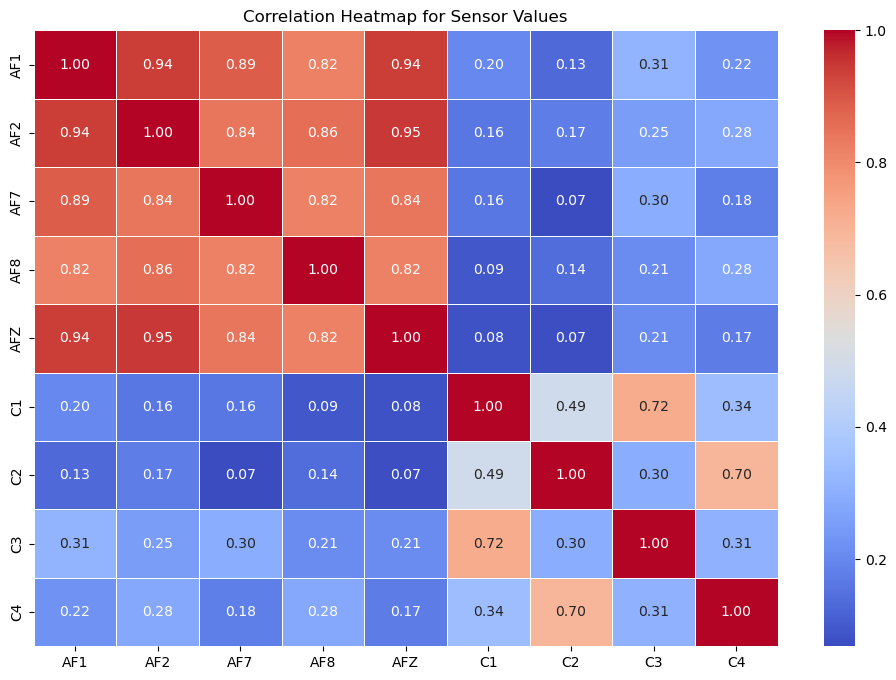

In [27]:
# Correlation heatmap between sensor columns
sensor_columns = ['AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4'] 
corr_matrix = train_df[sensor_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Sensor Values')
plt.show()


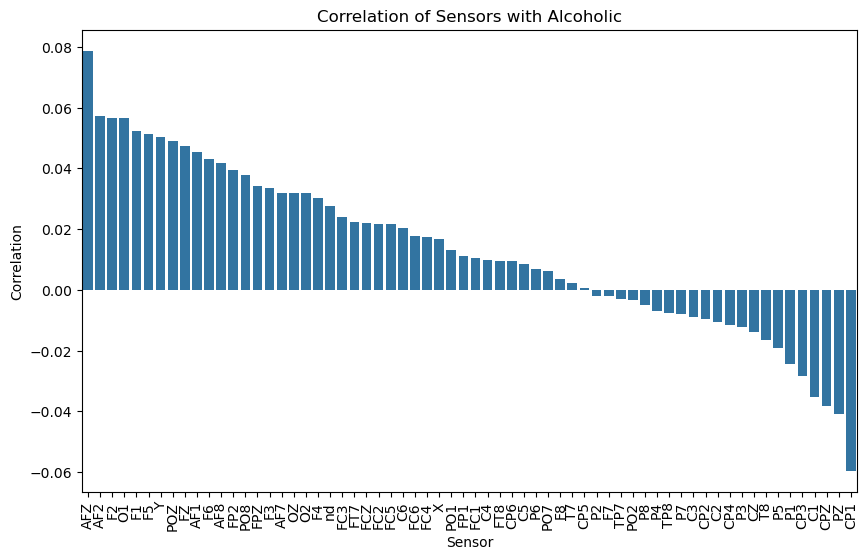

In [31]:
#C orrelation of alcoholic with EEG Data
from scipy.stats import pointbiserialr

sensor_columns = [col for col in train_df.columns if col not in ['sample', 'subject', 'alcoholic', 'match', 'err', 'object']]

correlations = {}
for col in sensor_columns:
    corr, _ = pointbiserialr(train_df['alcoholic'].astype(int), train_df[col])
    correlations[col] = corr

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Sensor', 'Correlation with Alcoholic'])
correlation_df = correlation_df.sort_values(by='Correlation with Alcoholic', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=correlation_df, x='Sensor', y='Correlation with Alcoholic')
plt.xticks(rotation=90)
plt.title('Correlation of Sensors with Alcoholic')
plt.xlabel('Sensor')
plt.ylabel('Correlation')
plt.show()




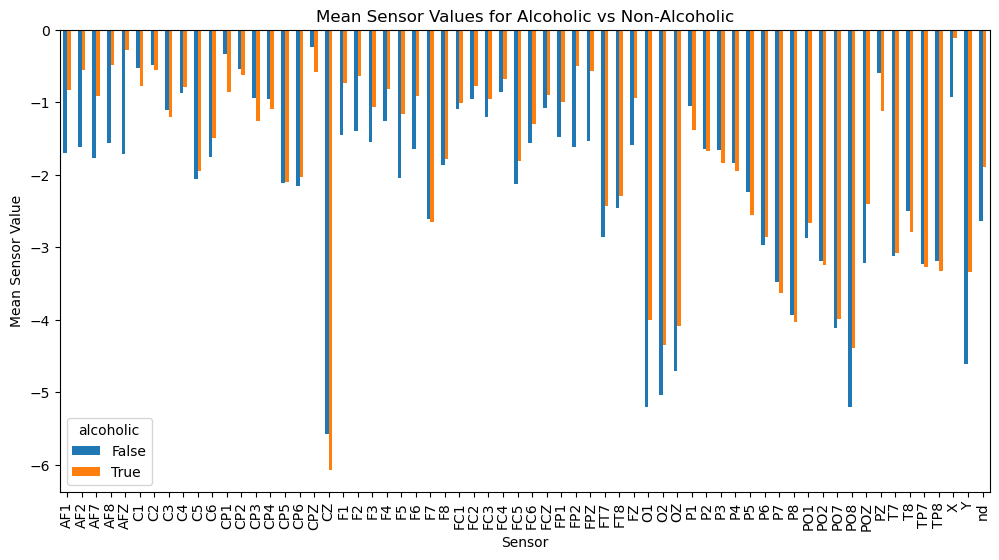

In [32]:
#Group-wise Statistics on Sensor Data (by alcoholic status)
alcoholic_grouped = train_df.groupby('alcoholic')[sensor_columns].mean()
alcoholic_grouped.T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Sensor Values for Alcoholic vs Non-Alcoholic')
plt.ylabel('Mean Sensor Value')
plt.xlabel('Sensor')
plt.xticks(rotation=90)
plt.show()

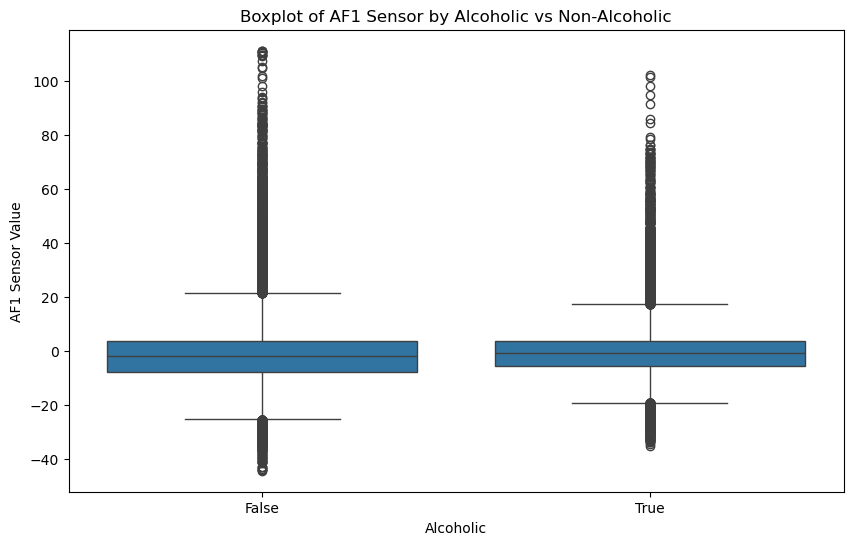

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='alcoholic', y='AF1')
plt.title('Boxplot of AF1 Sensor by Alcoholic vs Non-Alcoholic')
plt.xlabel('Alcoholic')
plt.ylabel('AF1 Sensor Value')
plt.show()


In [40]:
# Statistical Test: T-test (AF1 sensor)
from scipy.stats import ttest_ind

alcoholic_values = train_df[train_df['alcoholic'] == True]['AF1']
non_alcoholic_values = train_df[train_df['alcoholic'] == False]['AF1']

# T-test
t_stat, p_value = ttest_ind(alcoholic_values, non_alcoholic_values)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 17.769254736700304, P-value: 1.4396739505977124e-70


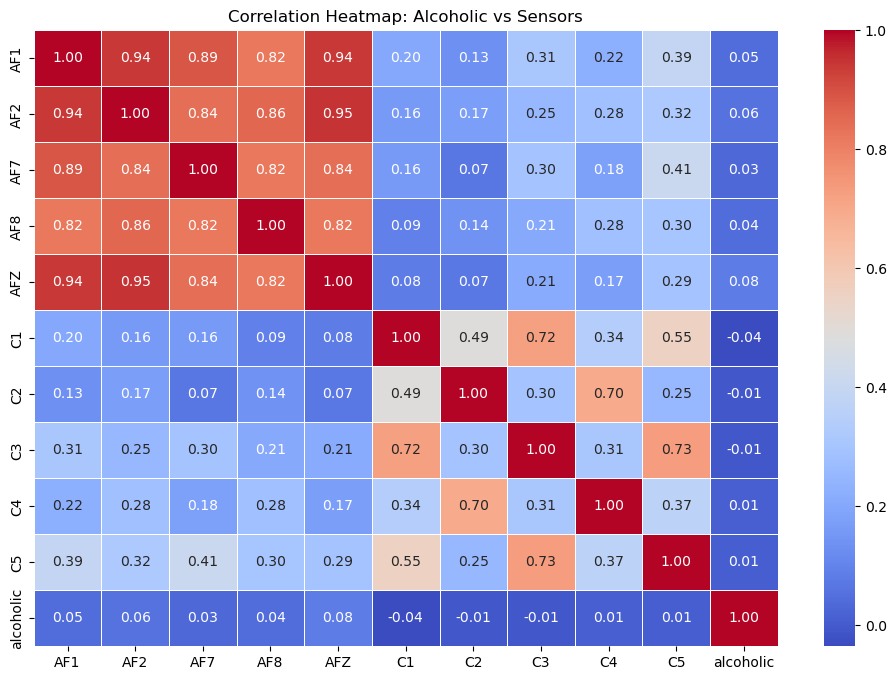

In [39]:
# Correlation matrix for alcoholic and sensors (first 10)
correlation_matrix = train_df[sensor_columns[0:10] + ['alcoholic']].apply(pd.to_numeric, errors='coerce').corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Alcoholic vs Sensors')
plt.show()


### Model

In [41]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [42]:
X = train_df.drop(columns=['alcoholic', 'subject', 'match', 'err', 'object'])  # Drop non-feature columns
y = train_df['alcoholic']

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=3)  # You can tune n_neighbors here
accuracies = []

for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the KNN classifier
    knn.fit(X_train, y_train)
    
    # Make prediction
    y_pred = knn.predict(X_test)
    
    # Evaluate the prediction
    accuracies.append(accuracy_score(y_test, y_pred))

In [ ]:
# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy:.4f}")